# Classificação de Texto usando CNN

Neste notebook vamos trabalhar com a tarefa de classificação de emails usando uma [Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network).

Primeiramente importamos as bibliotecas necessárias:

In [114]:
import torch
import torch.nn as nn
from torchtext.legacy import data as ttd
import torch.nn.functional as F
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

Em seguida, obtemos o conjunto de dados:

In [115]:
!wget -nc https://gist.githubusercontent.com/the-akira/9280f786082bdd23c7717284833f72c4/raw/bb639bec021e14960c07f679c4995b281d03bb7f/spam.csv

--2021-06-22 17:27:17--  https://gist.githubusercontent.com/the-akira/9280f786082bdd23c7717284833f72c4/raw/bb639bec021e14960c07f679c4995b281d03bb7f/spam.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 498960 (487K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 487.27K  --.-KB/s    in 0.04s   

2021-06-22 17:27:17 (11.4 MB/s) - ‘spam.csv’ saved [498960/498960]



Carregamos o conjunto de dados em um DataFrame pandas:

In [116]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [117]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Eliminamos as colunas desnecessárias:

In [118]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [119]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Renomeamos as colunas adequadamente:

In [120]:
df.columns = ['labels', 'data']

In [121]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


A seguir, criaremos labels (rótulos) binários:

In [122]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

E então definimos um novo DataFrame:

In [123]:
df2 = df[['data', 'b_labels']]

In [124]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Exportamos o novo DataFrame (**df2**) para um arquivo CSV:

In [125]:
df2.to_csv('spam2.csv', index=False)

Criamos dois objetos **Field**:

In [126]:
TEXT = ttd.Field(sequential=True, batch_first=True, lower=False, pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

E criamos um objeto **TabularDataset**:

In [127]:
dataset = ttd.TabularDataset(
    path='spam2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

Dividimos os dados em um conjunto de treinamento e outro de teste:

In [128]:
train_dataset, test_dataset = dataset.split()

Construímos um vocabulário com a função **build_vocab**:

In [129]:
TEXT.build_vocab(train_dataset,)

In [130]:
vocab = TEXT.vocab
print(vocab.itos)

['<unk>', '<pad>', 'to', 'you', 'I', 'a', 'the', 'and', 'in', 'is', 'i', 'u', 'my', 'for', 'of', 'your', 'me', 'on', 'have', '2', 'that', 'are', 'it', 'call', 'or', 'at', 'with', 'be', 'not', 'will', 'get', 'ur', 'but', 'so', '&lt;#&gt;', 'can', "I'm", 'U', '.', 'from', 'You', '4', 'when', 'just', 'we', 'all', 'if', 'like', 'this', 'know', 'go', 'up', 'out', 'do', 'now', 'was', 'come', 'got', 'am', '?', '...', 'by', 'Call', 'send', 'what', 'about', 'want', 'only', 'going', 'time', 'one', 'its', 'no', 'But', 'How', 'We', 'as', "I'll", 'our', 'then', 'text', 'there', 'Just', 'So', 'n', 'need', 'r', 'still', 'has', 'If', 'No', "don't", 'he', 'an', 'been', 'love', 'home', 'Ã\x8c_', 'how', 'Do', 'her', 'see', 'think', 'some', 'tell', 'good', 'any', 'back', 'd', 'free', 'they', 'Your', '&', 'make', 'me.', 'The', 'And', 'Ok', 'What', 'day', 'A', 'give', 'who', '-', 'mobile', 'My', 'dont', 'now.', 'take', 'Have', 'FREE', 'him', 'new', 'much', 'phone', "i'm", 'more', 'you.', 'she', '&amp;', 'as

Selecionamos o dispositivo de processamento disponível:

In [131]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Criamos os iteradores e iteramos sob eles:

In [132]:
train_iter, test_iter = ttd.Iterator.splits((train_dataset, test_dataset), sort_key=lambda x: len(x.data), batch_sizes=(32, 256), device=device)

Qual é a forma (shape) de embedding output?

N x T x D

In [133]:
embed = nn.Embedding(len(vocab), 20).to(device)

for inputs, targets in train_iter:
    out = embed(inputs)
    print("input shape:", inputs.shape, "output shape:", out.shape)
    break

input shape: torch.Size([32, 70]) output shape: torch.Size([32, 70, 20])


Definimos o nosso modelo de classificação:

In [134]:
class CNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_outputs):
        super(CNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.K = n_outputs

        # if input is T words
        # then output is (T, D) matrix
        self.embed = nn.Embedding(self.V, self.D)

        # conv layers
        self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 128, 3, padding=1)

        self.fc = nn.Linear(128, self.K)

    def forward(self, X):
        # embedding layer
        # turns word indexes into word vectors
        out = self.embed(X)

        # note: output of embedding is always
        # (N, T, D)
        # conv1d expects
        # (N, D, T)

        # conv layers
        out = out.permute(0, 2, 1)
        out = self.conv1(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = F.relu(out)

        # change it back
        out = out.permute(0, 2, 1)

        # max pool
        out, _ = torch.max(out, 1)

        # final dense layer
        out = self.fc(out)
        return out

Instanciamos o modelo:

In [135]:
model = CNN(len(vocab), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(12731, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Definimos a função Loss e o Otimizador:

In [136]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

Criamos uma função para encapsular o loop de treinamento:

In [137]:
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_iter:
            targets = targets.view(-1, 1).float()
            # move os dados para o dispositivo de processamento
            inputs, targets = inputs.to(device), targets.to(device)

            # zera os parâmetros do gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward e optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Obtém o loss de treinamento e teste
        train_loss = np.mean(train_loss) 

        test_loss = []
        for inputs, targets in test_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Salva os losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
            Test Loss: {test_loss:.4f}, Duration: {dt}')

    return train_losses, test_losses

Treinamos o nosso modelo:

In [138]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_iter, test_iter, 5)

Epoch 1/5, Train Loss: 0.3993,             Test Loss: 0.4706, Duration: 0:00:01.713912
Epoch 2/5, Train Loss: 0.2847,             Test Loss: 0.4480, Duration: 0:00:01.604717
Epoch 3/5, Train Loss: 0.1836,             Test Loss: 0.2203, Duration: 0:00:01.584746
Epoch 4/5, Train Loss: 0.1147,             Test Loss: 0.1563, Duration: 0:00:01.559204
Epoch 5/5, Train Loss: 0.0844,             Test Loss: 0.1500, Duration: 0:00:01.554961


Plotamos a loss de treinamento e teste por iteração:

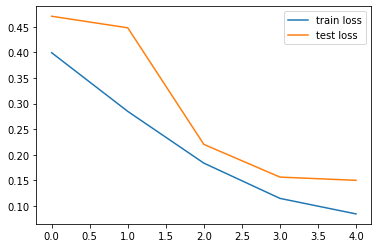

In [139]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

Por fim, calculamos a **Accuracy** do modelo:

In [140]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Obtemos previsões
    predictions = (outputs > 0)

    # Atualizamos os contadores
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)

    # Obtemos previsões
    predictions = (outputs > 0)

    # Atualizamos os contadores
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9841, Test acc: 0.9581
